In [1]:
# package imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 

In [2]:
gss = pd.read_csv('Data/gss18.csv', low_memory=False)

In [3]:
interesting_variables = ['LONELY2', 'SATJOB', 'MOREDAYS', 'WRKHOME', 'HLTHPHYS', 'HLTHMNTL', 'CONWKDAY', 'PARTLSC', 'AGE','MARITAL', 'EDUC']
# testing ridding of s
# GSS rid of HOMPOP, will HOUSEHOLD SIZE use from AARP
gss = gss[interesting_variables]

## Preprocessing

In [4]:
# how many nulls?
# Loop through each column
# and check the amount of nulls.
# Only print if there are more than 0.

for col in gss.columns:
    if gss[col].isnull().sum() > 0:
        print(f'{round(gss[col].isnull().sum()/gss.shape[0],3)}%\t{gss[col].isnull().sum()} null values in {col}')

0.503%	1182 null values in LONELY2
0.259%	609 null values in SATJOB
0.403%	947 null values in MOREDAYS
0.396%	930 null values in WRKHOME
0.008%	19 null values in HLTHPHYS
0.008%	19 null values in HLTHMNTL
0.503%	1180 null values in CONWKDAY
0.503%	1182 null values in PARTLSC
0.003%	7 null values in AGE
0.001%	2 null values in MARITAL
0.001%	3 null values in EDUC


In [5]:
# recode social isolation
gss['is_si'] = gss['LONELY2'].apply(lambda x: 1 if (x == 3 or x == 4 or x == 5) else 0)

In [6]:
# bin wkdays
bins = [-1,0,7,14,21,31]#pd.IntervalIndex.from_tuples([(-1,1), (1, 7), (7, 14), (14, 21),(21,30)])


gss['MOREWEEKS'] = pd.cut(gss['MOREDAYS'],bins,labels=['0','1','2','3','4'])

In [7]:
bins = [18,29,44,59,89]#,pd.IntervaIndex.from_tuples([(18, 29), (30, 44), (45, 59),(60,89)])


gss['Age Group'] = pd.cut(gss['AGE'],bins,labels=[1,2,3,4])

####### Age group ########

In [8]:
bins= [0,11,12,15,21]
gss['EDUC'] = pd.cut(gss['EDUC'],bins,labels=[1,2,3,4])#labels=['No HS Diploma','HS Graduate','Some College','BA or Above'])
######## EDUCATION ######

## Decision Tree

In [9]:
clf = DecisionTreeClassifier(random_state=0)

In [10]:
gss = gss.dropna()
for colm in gss.columns:
    print(f'{colm}: \t{gss[colm].unique()}')

LONELY2: 	[2. 3. 1. 4. 5.]
SATJOB: 	[1. 2. 3. 4.]
MOREDAYS: 	[ 2.  1. 24.  3.  6.  0. 15. 30. 20. 12. 18.  5.  4. 10. 26. 25.  8. 28.
  7. 17. 22. 14. 23.  9. 16.]
WRKHOME: 	[1. 4. 5. 6. 2. 3.]
HLTHPHYS: 	[1. 3. 2. 4. 5.]
HLTHMNTL: 	[1. 2. 3. 4. 5.]
CONWKDAY: 	[4. 3. 2. 6. 1. 5.]
PARTLSC: 	[3. 2. 5. 1. 4.]
AGE: 	[63. 59. 43. 55. 34. 44. 40. 30. 20. 65. 46. 22. 23. 28. 37. 42. 21. 70.
 53. 29. 50. 56. 67. 54. 48. 76. 39. 69. 60. 35. 38. 26. 57. 19. 36. 61.
 33. 51. 58. 45. 52. 25. 27. 24. 77. 47. 74. 32. 31. 72. 66. 68. 49. 64.
 41. 71. 78. 75. 85. 73. 62. 89.]
MARITAL: 	[1. 3. 5. 4. 2.]
EDUC: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]
is_si: 	[0 1]
MOREWEEKS: 	['1', '4', '0', '3', '2']
Categories (5, object): ['0' < '1' < '2' < '3' < '4']
Age Group: 	[4, 3, 2, 1]
Categories (4, int64): [1 < 2 < 3 < 4]


### make x and y

In [11]:
x = gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss['is_si']
x.shape

(688, 10)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)#,stratify=x['MOREWEEKS'])

In [13]:
# decision tree regular fit
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.6447368421052632

In [14]:
# baseline
gss['is_si'].value_counts()[0]/gss['is_si'].value_counts().sum()
# 79% baseline. awkward.

0.7558139534883721

In [15]:
# 79%... what quantities?
gss['is_si'].value_counts()

0    520
1    168
Name: is_si, dtype: int64

In [16]:
# prepare grid search
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [17]:
# do the grid search
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [18]:
CV_DT.score(x_test, y_test)

0.7631578947368421

In [19]:
x.head()

,SATJOB,WRKHOME,HLTHPHYS,HLTHMNTL,CONWKDAY,PARTLSC,MARITAL,EDUC,MOREWEEKS,Age Group
3,1.0,1.0,1.0,1.0,4.0,3.0,1.0,4,1,4
6,1.0,1.0,3.0,2.0,3.0,2.0,3.0,3,1,3
7,1.0,1.0,2.0,3.0,4.0,5.0,5.0,2,4,2
9,2.0,1.0,2.0,3.0,4.0,1.0,1.0,2,1,3
11,2.0,1.0,3.0,3.0,2.0,1.0,4.0,3,1,2


## upsampling is_si

In [20]:
to_resample = gss.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_rebal = pd.concat([gss, our_resample])

In [21]:
x = gss_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y = gss_rebal['is_si']
x.shape

(1084, 10)

In [22]:
gss_rebal['is_si'].value_counts()

1    564
0    520
Name: is_si, dtype: int64

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [24]:
clf.fit(x_train,y_train)
clf.score(x_test, y_test)

0.8631284916201117

In [25]:
param_grid = { 
    'max_leaf_nodes': range(2,1000,22),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 5), # again, steps of 25
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}

In [26]:
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [27]:
CV_DT.score(x_test, y_test)

0.8240223463687151

In [28]:
x.shape

(1084, 10)

In [29]:
for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
    print(f'{round(importance,3)}\t{feature}')

0.098	SATJOB
0.058	WRKHOME
0.047	HLTHPHYS
0.147	HLTHMNTL
0.111	CONWKDAY
0.094	PARTLSC
0.179	MARITAL
0.114	EDUC
0.072	MOREWEEKS
0.081	Age Group


In [30]:
# DT for each age category
for ages in gss['Age Group'].unique():
    print(f'---------- ages {ages}-----------')
    age_gss = gss_rebal.loc[gss_rebal['Age Group'] == ages]
    x = age_gss.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y = age_gss['is_si']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    clf.fit(x_train,y_train)
    print(f'{round(clf.score(x_test, y_test),3)}% {ages}')
    
    for importance, feature in zip(clf.feature_importances_, clf.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')

---------- ages 4-----------
0.837% 4
0.042	SATJOB
0.058	WRKHOME
0.046	HLTHPHYS
0.146	HLTHMNTL
0.139	CONWKDAY
0.07	PARTLSC
0.406	MARITAL
0.052	EDUC
0.04	MOREWEEKS
0.0	Age Group
---------- ages 3-----------
0.881% 3
0.067	SATJOB
0.123	WRKHOME
0.082	HLTHPHYS
0.307	HLTHMNTL
0.076	CONWKDAY
0.143	PARTLSC
0.095	MARITAL
0.069	EDUC
0.039	MOREWEEKS
0.0	Age Group
---------- ages 2-----------
0.842% 2
0.047	SATJOB
0.073	WRKHOME
0.109	HLTHPHYS
0.155	HLTHMNTL
0.112	CONWKDAY
0.122	PARTLSC
0.192	MARITAL
0.031	EDUC
0.16	MOREWEEKS
0.0	Age Group
---------- ages 1-----------
0.811% 1
0.0	SATJOB
0.026	WRKHOME
0.191	HLTHPHYS
0.08	HLTHMNTL
0.101	CONWKDAY
0.181	PARTLSC
0.136	MARITAL
0.188	EDUC
0.097	MOREWEEKS
0.0	Age Group


[Text(0.4112755193409742, 0.9736842105263158, 'MARITAL <= 1.5\nentropy = 0.998\nsamples = 726\nvalue = [344, 382]\nclass = WRKHOME'),
 Text(0.11837392550143266, 0.9210526315789473, 'SATJOB <= 1.5\nentropy = 0.808\nsamples = 238\nvalue = [179, 59]\nclass = SATJOB'),
 Text(0.04620343839541547, 0.868421052631579, 'EDUC <= 1.5\nentropy = 0.647\nsamples = 133\nvalue = [111, 22]\nclass = SATJOB'),
 Text(0.04047277936962751, 0.8157894736842105, 'entropy = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = SATJOB'),
 Text(0.05193409742120344, 0.8157894736842105, 'HLTHMNTL <= 1.5\nentropy = 0.674\nsamples = 124\nvalue = [102, 22]\nclass = SATJOB'),
 Text(0.022922636103151862, 0.7631578947368421, 'Age Group <= 2.5\nentropy = 0.262\nsamples = 45\nvalue = [43, 2]\nclass = SATJOB'),
 Text(0.017191977077363897, 0.7105263157894737, 'EDUC <= 2.5\nentropy = 0.592\nsamples = 14\nvalue = [12, 2]\nclass = SATJOB'),
 Text(0.011461318051575931, 0.6578947368421053, 'CONWKDAY <= 3.5\nentropy = 0.918\nsamples = 6\nvalu

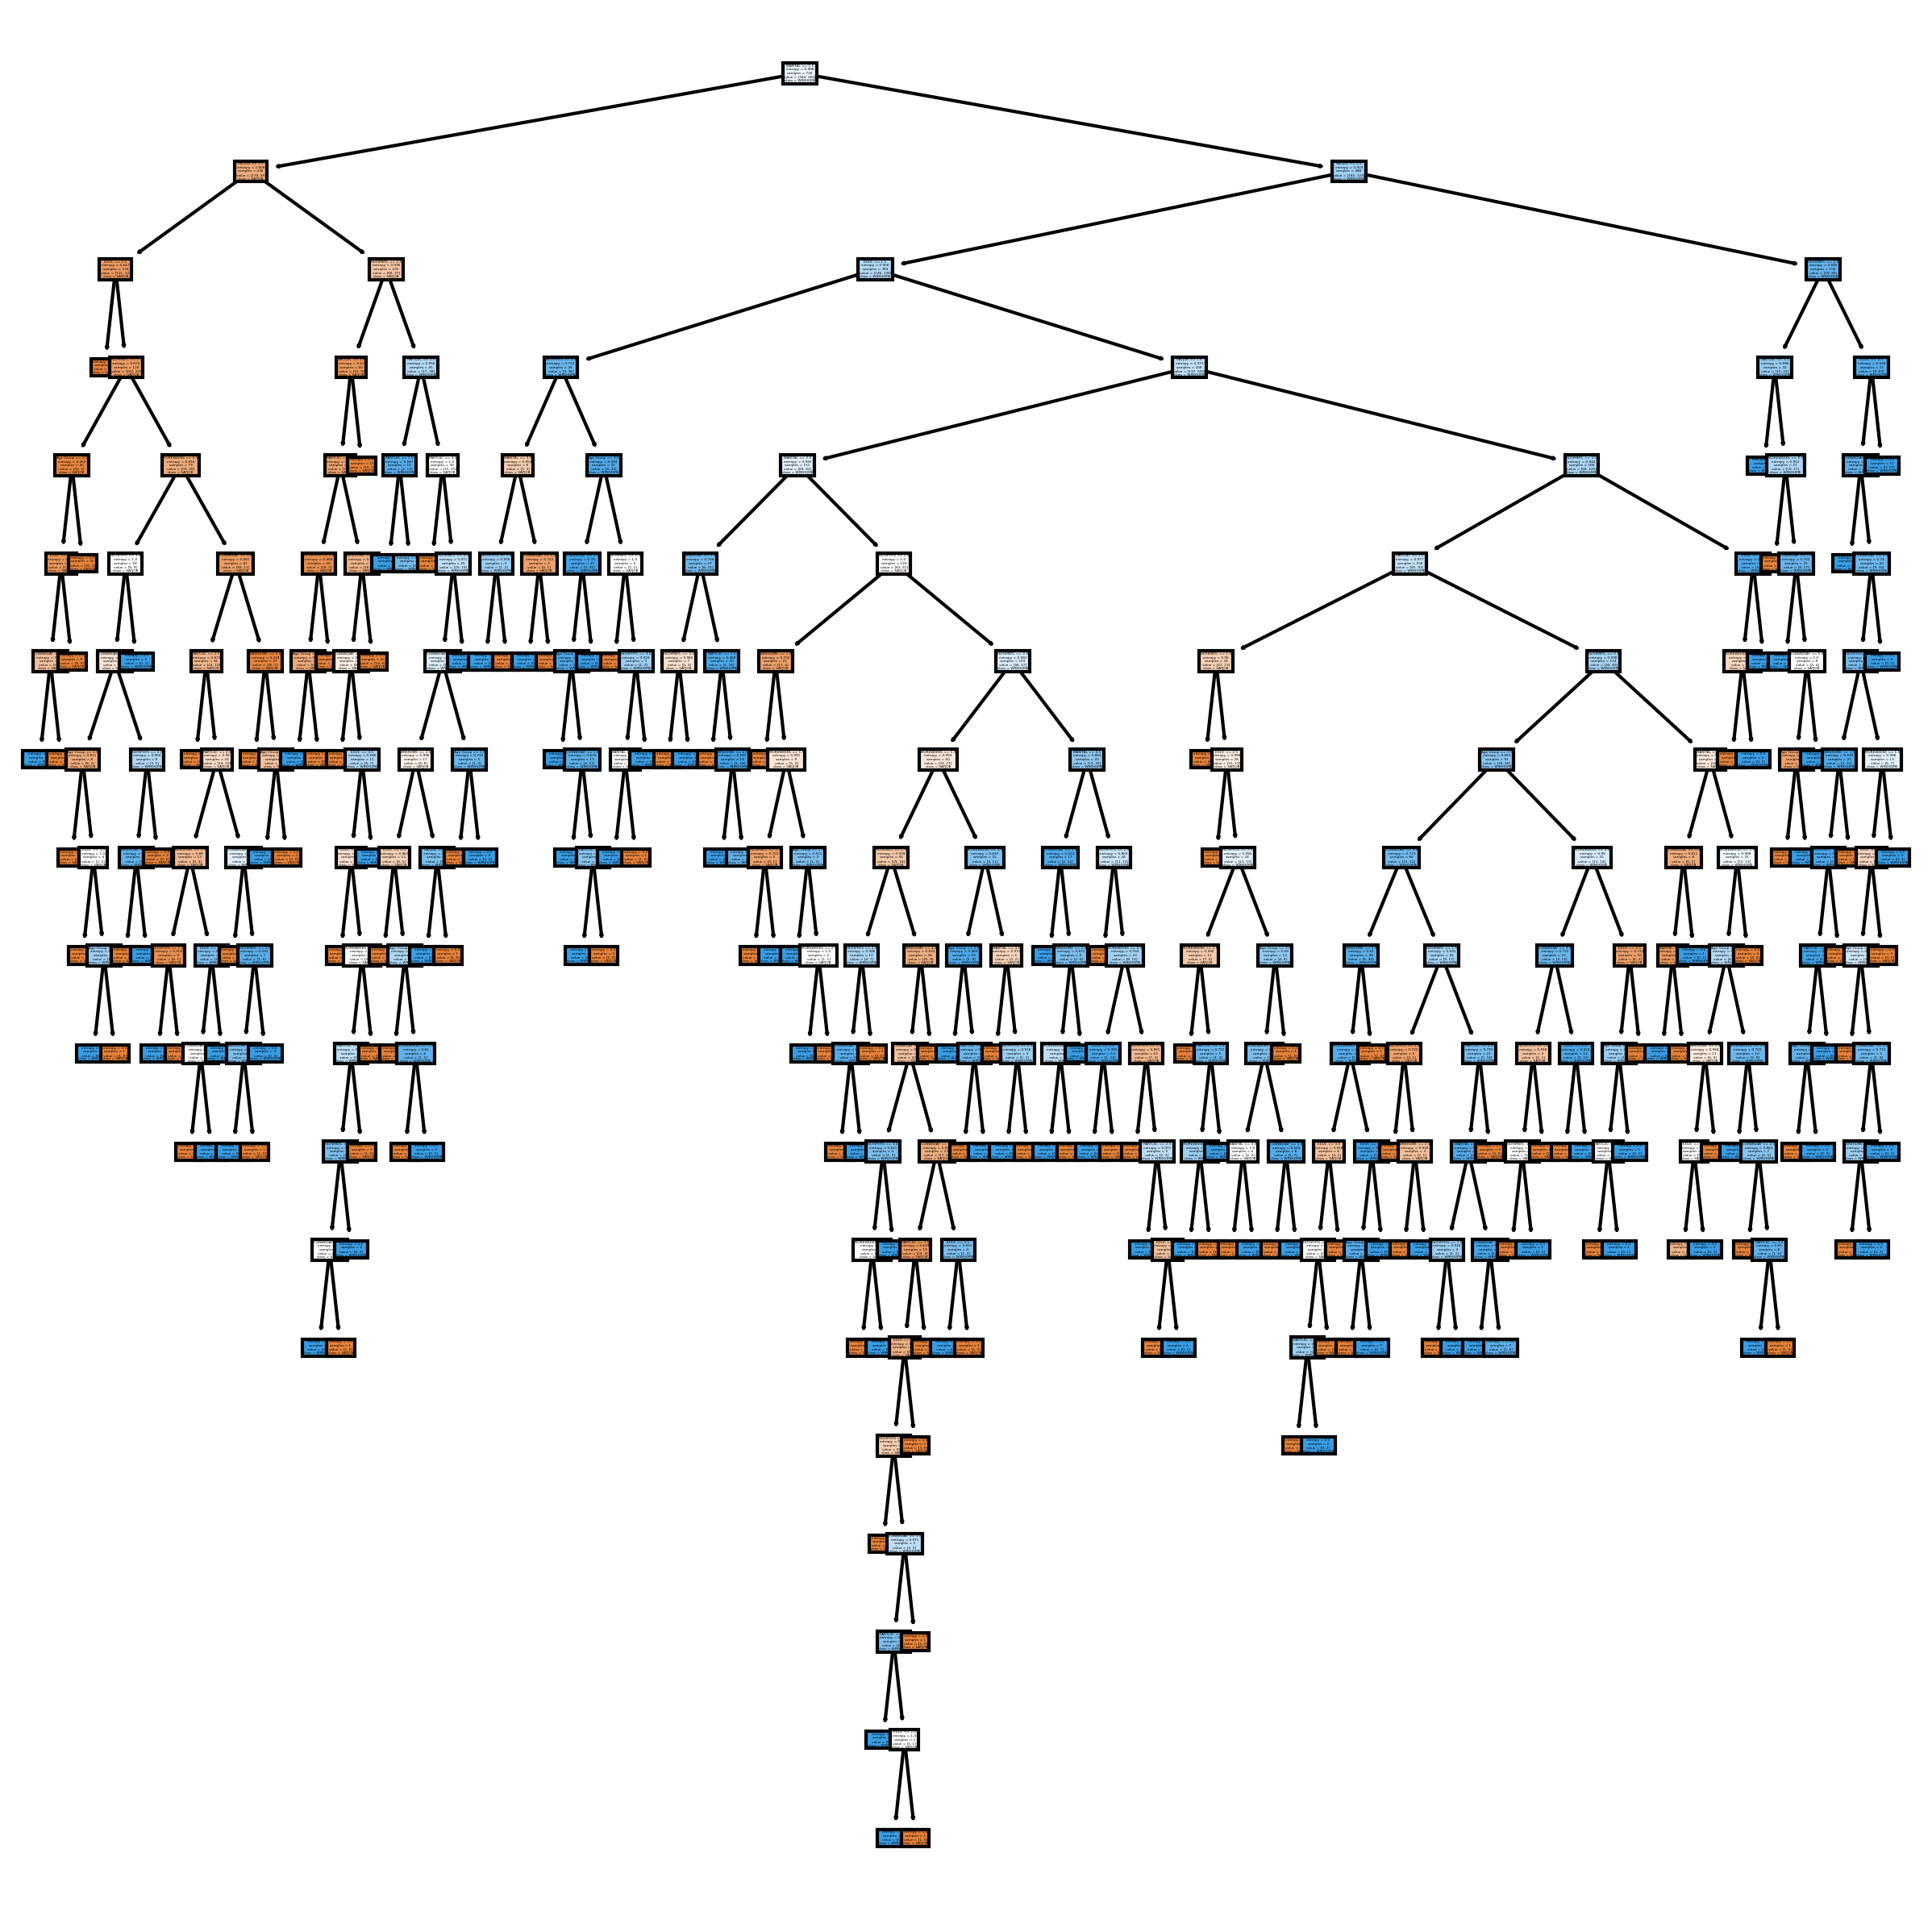

In [31]:
fix, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10), dpi=300)
tree.plot_tree(CV_DT.best_estimator_, feature_names = x.columns, class_names = CV_DT.feature_names_in_, filled = True)

In [32]:
# upsample training data only CHECK
# fix tree????
# trim down unncessary vars?
# make output legible CHECK
# seperate modeling from data manip, gss and aarp 
# linear 

## Upsampling only training data

In [33]:
# make train and test set
gss_train, gss_test = train_test_split(gss, test_size=0.33, random_state=42)

In [34]:
# upsample train set
to_resample = gss_train.loc[gss['is_si'] ==1]
our_resample = to_resample.sample(n = 396, replace = True)
gss_train_rebal = pd.concat([gss_train, our_resample])

In [35]:
# manually create x,y test and trains
x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
y_train = gss_train_rebal['is_si']
y_test = gss_test['is_si']

In [36]:
# grid search it yeah
CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
CV_DT.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(1, 100, 5),
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': range(2, 1000, 22)})

In [37]:
CV_DT.score(x_test, y_test)

0.6798245614035088

In [ ]:
# DT for each age category
for ages in gss['Age Group'].unique():
    #print(f'---------- ages {ages} -----------')
    
    # grab gss for single age group
    aged_gss = gss.loc[gss['Age Group'] == ages]
    
    # split into train and test
    gss_train, gss_test = train_test_split(aged_gss, test_size=0.33, random_state=42)
    # upsample train set
    if gss_train['is_si'].value_counts()[0] - aged_gss['is_si'].value_counts()[1] > 0:
        amt_to_rebal = gss_train['is_si'].value_counts()[0] - gss_train['is_si'].value_counts()[1]
        # upsample train set
        to_resample = gss_train.loc[gss_train['is_si'] == 1]
        our_resample = to_resample.sample(n = amt_to_rebal, replace = True)
        gss_train_rebal = pd.concat([gss_train, our_resample])
        
    else:
        amt_to_rebal = (gss_train['is_si'].value_counts()[0] - gss_train['is_si'].value_counts()[1]) * -1
        # upsample train set
        to_resample = gss_train.loc[gss_train['is_si'] == 0]
        our_resample = to_resample.sample(n = amt_to_rebal, replace = True)
        gss_train_rebal = pd.concat([gss_train, our_resample])

    
    # manually create x,y test and trains
    x_train = gss_train_rebal.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    x_test = gss_test.drop(['LONELY2', 'MOREDAYS', 'AGE', 'is_si'], axis=1)
    y_train = gss_train_rebal['is_si']
    y_test = gss_test['is_si']
    
    # new decision tree
    clf = DecisionTreeClassifier(random_state=42)
    
    # grid to search
    param_grid = { 
    'max_leaf_nodes': range(2,1000,11),
    'max_features': ['auto', 'sqrt', 'log2'], # all of the feature types
    'max_depth' : range(1,100, 3),
    'criterion' :['gini', 'entropy', 'log_loss'], # the two common criterion 
    'max_features': ['sqrt', 'log2', None]
}
    # new grid search using decision tree and grid from above
    CV_DT = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5, n_jobs=-1) 
    
    # let's 'train'
    CV_DT.fit(x_train, y_train)
    
    # print the results
    print(f'---------- score for age {ages}: {round(CV_DT.score(x_test, y_test),3)}% ----------')
    
    for importance, feature in zip(CV_DT.best_estimator_.feature_importances_, CV_DT.feature_names_in_):
        print(f'{round(importance,3)}\t{feature}')
        
    ###### print train and test set sizes
    print(f'training set size: \n{y_train.value_counts()}')
    print(f'testing set size:  \n{y_test.value_counts()}')
    ###### 

---------- score for age 4: 0.758% ----------
0.012	SATJOB
0.153	WRKHOME
0.113	HLTHPHYS
0.279	HLTHMNTL
0.151	CONWKDAY
0.049	PARTLSC
0.116	MARITAL
0.103	EDUC
0.024	MOREWEEKS
0.0	Age Group
training set size: 
1    49
0    49
Name: is_si, dtype: int64
testing set size:  
0    28
1     5
Name: is_si, dtype: int64
